# Anàlisis del retràs dels trens polonesos
## Treball cas Kaggle
##### Catalina Mascaró Català - 1708159 i  Mathilde Buffard - 1775251

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline

from matplotlib.gridspec import GridSpec
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, precision_score, recall_score, roc_curve, auc, precision_recall_curve, classification_report, average_precision_score

from time import time
from scipy.interpolate import splrep, BSpline

%matplotlib inline

In [2]:
df = pd.read_csv('./train_delay_data.csv') # Dataset descarregat desde https://www.kaggle.com/datasets/ravisingh0399/train-delay-dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Distance Between Stations (km)  2878 non-null   int64 
 1   Weather Conditions              2878 non-null   object
 2   Day of the Week                 2878 non-null   object
 3   Time of Day                     2878 non-null   object
 4   Train Type                      2878 non-null   object
 5   Historical Delay (min)          2878 non-null   int64 
 6   Route Congestion                2878 non-null   object
dtypes: int64(2), object(5)
memory usage: 157.5+ KB


In [4]:
df.head()

,Distance Between Stations (km),Weather Conditions,Day of the Week,Time of Day,Train Type,Historical Delay (min),Route Congestion
0,100,Clear,Monday,Morning,Express,5,Low
1,150,Rainy,Tuesday,Afternoon,Superfast,10,Medium
2,200,Foggy,Wednesday,Evening,Local,15,High
3,50,Clear,Thursday,Night,Express,2,Low
4,75,Rainy,Friday,Morning,Superfast,8,Medium


In [5]:
df.describe()

,Distance Between Stations (km),Historical Delay (min)
count,2878.000000,2878.000000
mean,184.423211,93.324878
std,169.394783,195.923817
min,0.000000,0.000000
25%,70.000000,13.000000
50%,155.000000,35.000000
75%,225.000000,74.000000
max,955.000000,1230.000000


Veiem que la nostra base de dades no té dades faltants o incompletes. Les columnes "Distance Between Stations (km)" i "Historical Delay (min)" són integers, mentre que la resta són variables categòriques.

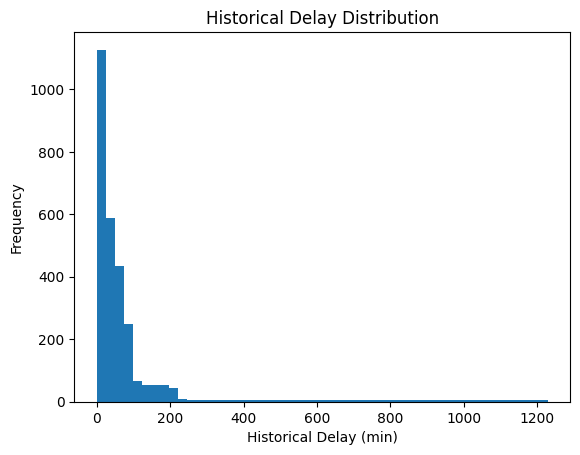

In [6]:
df["Historical Delay (min)"].plot(kind='hist', bins=50, title='Historical Delay Distribution')
plt.xlabel('Historical Delay (min)')
plt.show()

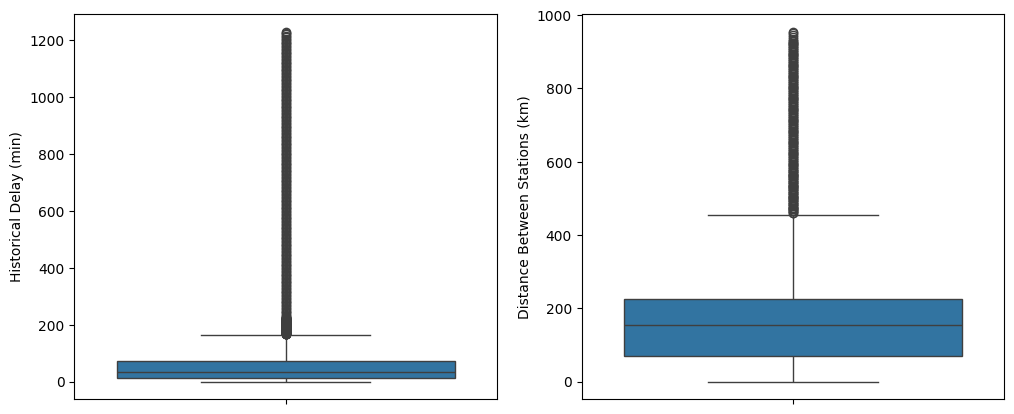

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y='Historical Delay (min)', data=df, ax=axes[0])
sns.boxplot(y='Distance Between Stations (km)', data=df, ax=axes[1])
plt.show()

Decidim convertir les variables categòriques "Weather Conditions", "Day of the Week", "Time of Day" i "Train Type" en un conjunt de variables binàries equivalent. A més, la variable "Route Congestion", que és categòrica però ordenada, la substituïm per valors numerics: 1-low, 2-medium, 3-high.

Observant la distribució de la variable objectiu ("Historical Delay (min)"), veiem que té valors molt dispars, (fins unes 22h de retràs). Davant això, decidim fer un primer model classificador per separar les dades que tenen molt retràs, i les que en tenen poc. Agafem un llindar de 60 min com a frontera observant el gràfic, però amb més dades es podria ajustar aquest valor en forma d'hiperparàmetre. Sobre els dos grups, aplicarem tècniques de regressió per predir el retràs dels trens.

Per tant, afegim una variable anomenada "Delay", que servirà com a variable objectiu del primer classificador.

In [8]:
weather = pd.get_dummies(df['Weather Conditions'],drop_first=True)
days = pd.get_dummies(df['Day of the Week'],drop_first=True)
time = pd.get_dummies(df['Time of Day'], drop_first=True)
train = pd.get_dummies(df['Train Type'], drop_first=True)
df['congest'] = pd.Categorical(
    df['Route Congestion'],
    categories=['Low', 'Medium', 'High'],
    ordered=True
)

df['congest'] = df['congest'].cat.codes + 1
delay = df['Historical Delay (min)'].apply(lambda x: 1 if x > 60 else 0)
delay.name = 'Delay' #0: Poco Delay, 1: Delay > 60 mins

df.drop(['Weather Conditions','Day of the Week','Time of Day','Train Type','Route Congestion'],axis=1,inplace=True) 
df = pd.concat([df,weather,days,time,train, delay],axis=1) 
df.head()

,Distance Between Stations (km),Historical Delay (min),congest,Foggy,Rainy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Evening,Morning,Night,Local,Superfast,Delay
0,100,5,1,False,False,True,False,False,False,False,False,False,True,False,False,False,0
1,150,10,2,False,True,False,False,False,False,True,False,False,False,False,False,True,0
2,200,15,3,True,False,False,False,False,False,False,True,True,False,False,True,False,0
3,50,2,1,False,False,False,False,False,True,False,False,False,False,True,False,False,0
4,75,8,2,False,True,False,False,False,False,False,False,False,True,False,False,True,0


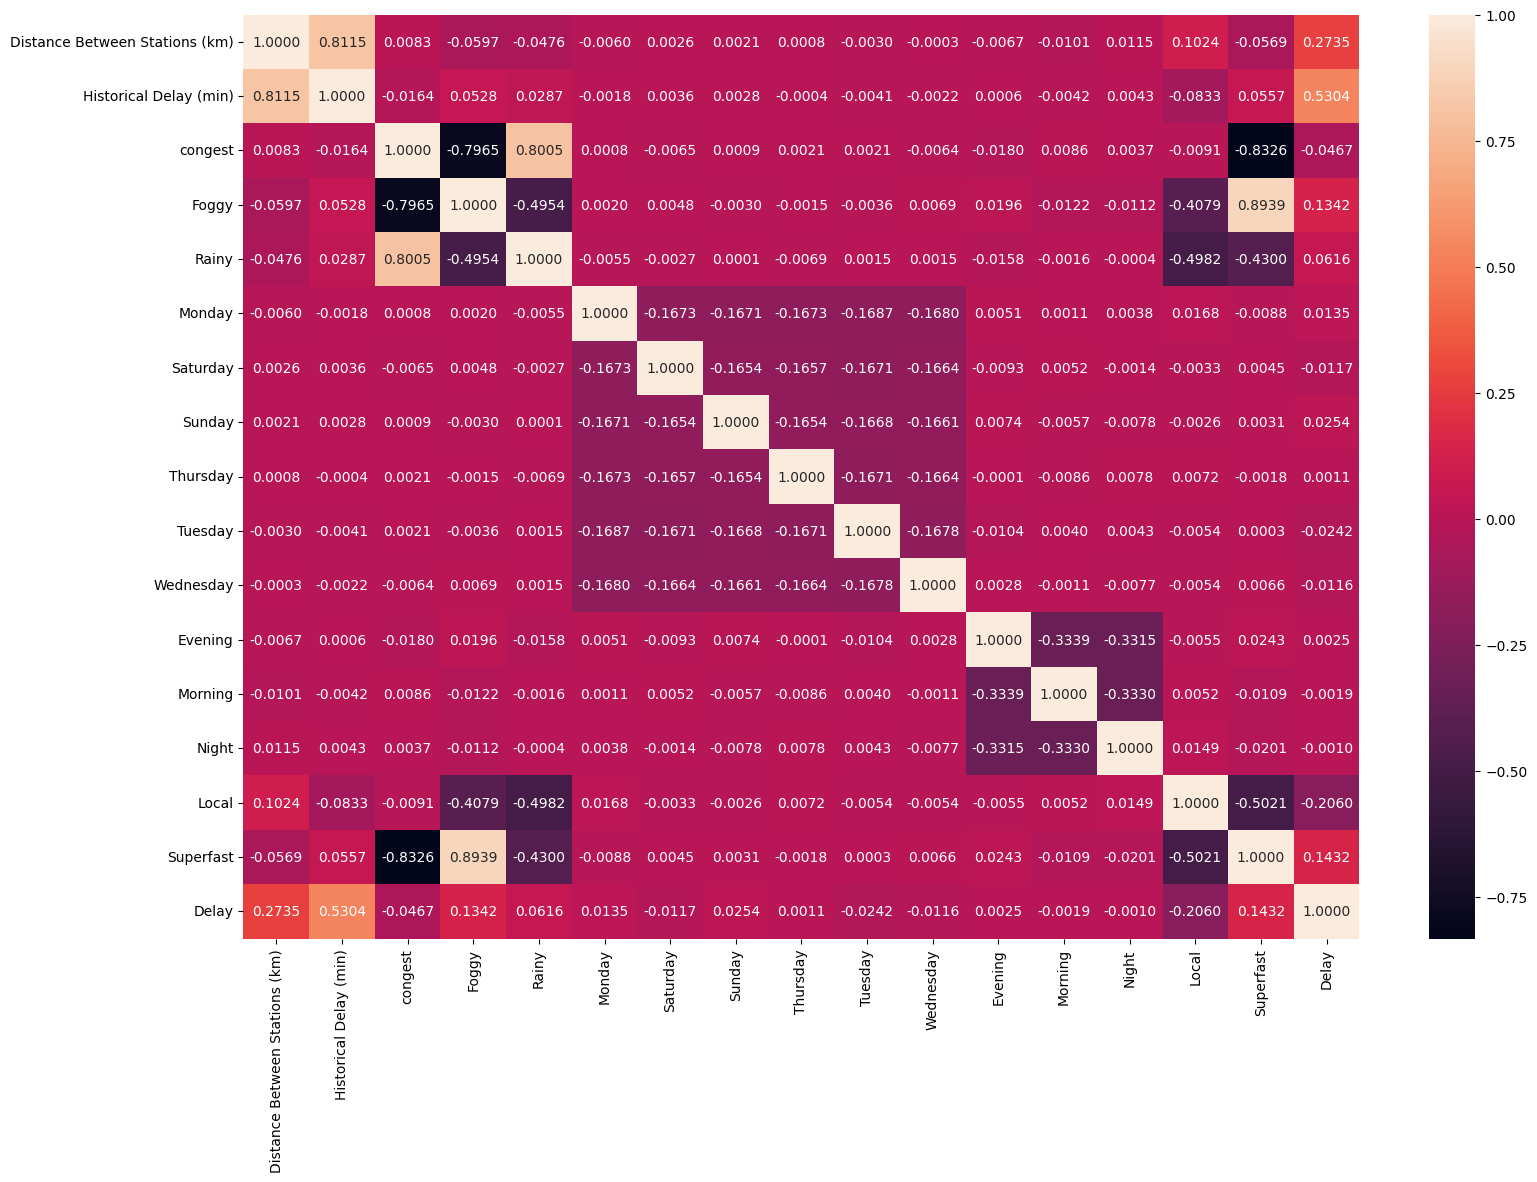

In [9]:
# Mirem les correlacions entre les variables
plt.figure(figsize=(18, 12))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".4f")
plt.show()

c:\Users\Usuari\Documents\uni\3r\Aprenentatge computacional\Kaggle\.venv\Lib\site-packages\matplotlib\axes\_axes.py:7132: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


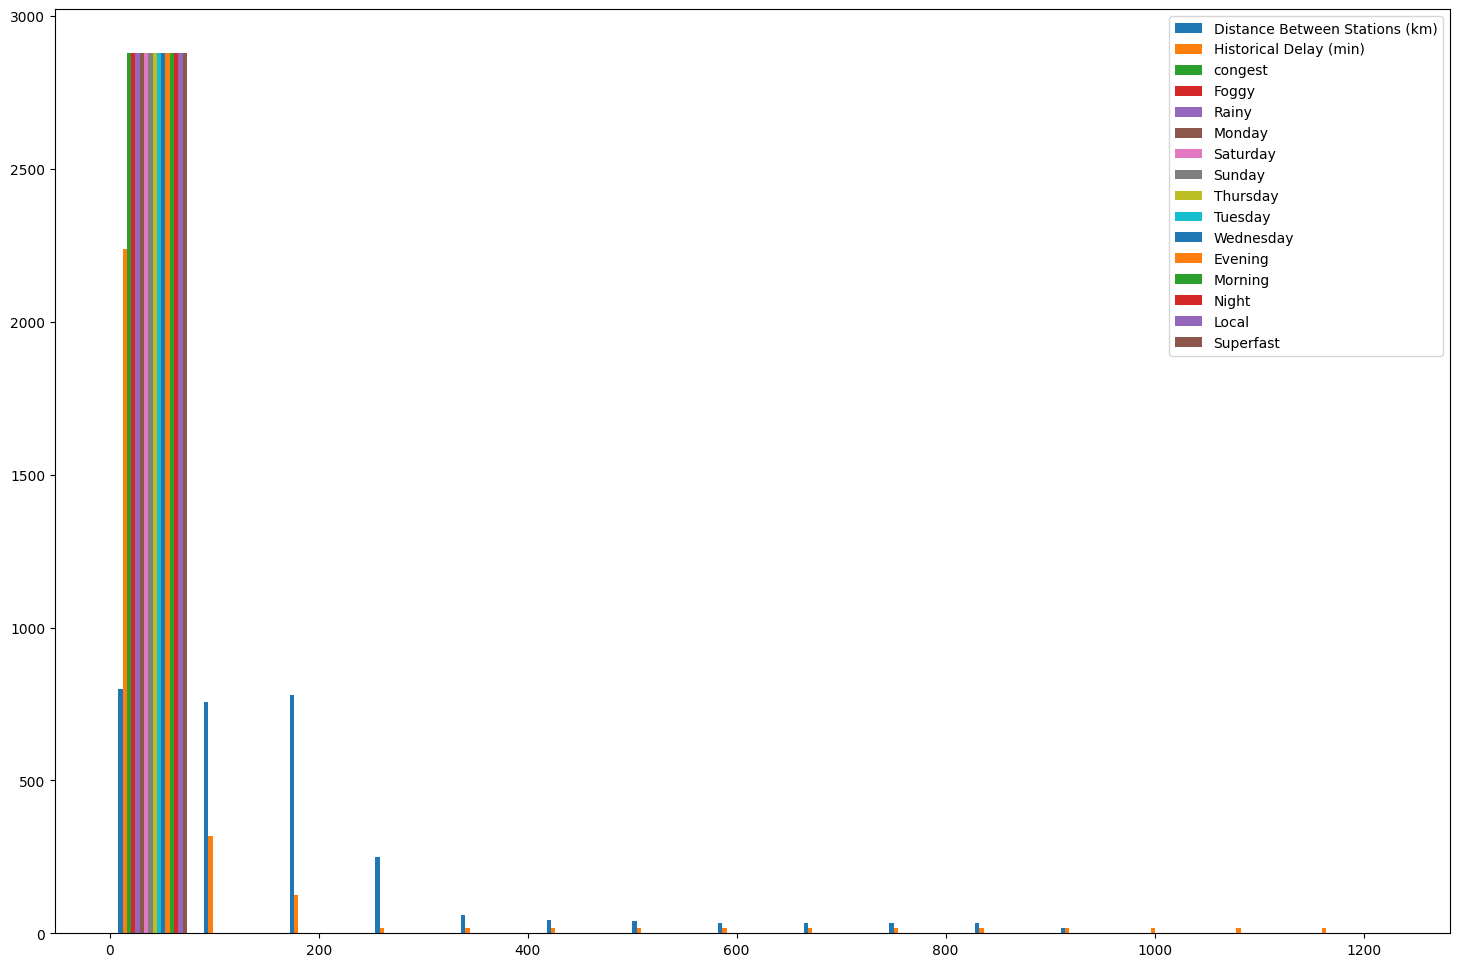

In [10]:
plt.figure(figsize=(18, 12))
plt.hist([df[c] for c in df.columns][:16], bins=15, label=[c for c in df.columns][:16])
plt.legend()
plt.show()

En aquest punt, decidim normalitzar les dades enteres, "Distance Between Stations (km)" i "Historical Delay (min)". Hem de tenir en compte que estem normalitzant també la variable objectiu, per això no eliminem les variables originals, ja que al final voldrem comparar el resultat del nostre model (en minuts, és a dir, amb una transformació inversa) amb el retràs original. Durant el procès, ignorarem les variables no normalitzades.

c:\Users\Usuari\Documents\uni\3r\Aprenentatge computacional\Kaggle\.venv\Lib\site-packages\matplotlib\axes\_axes.py:7132: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


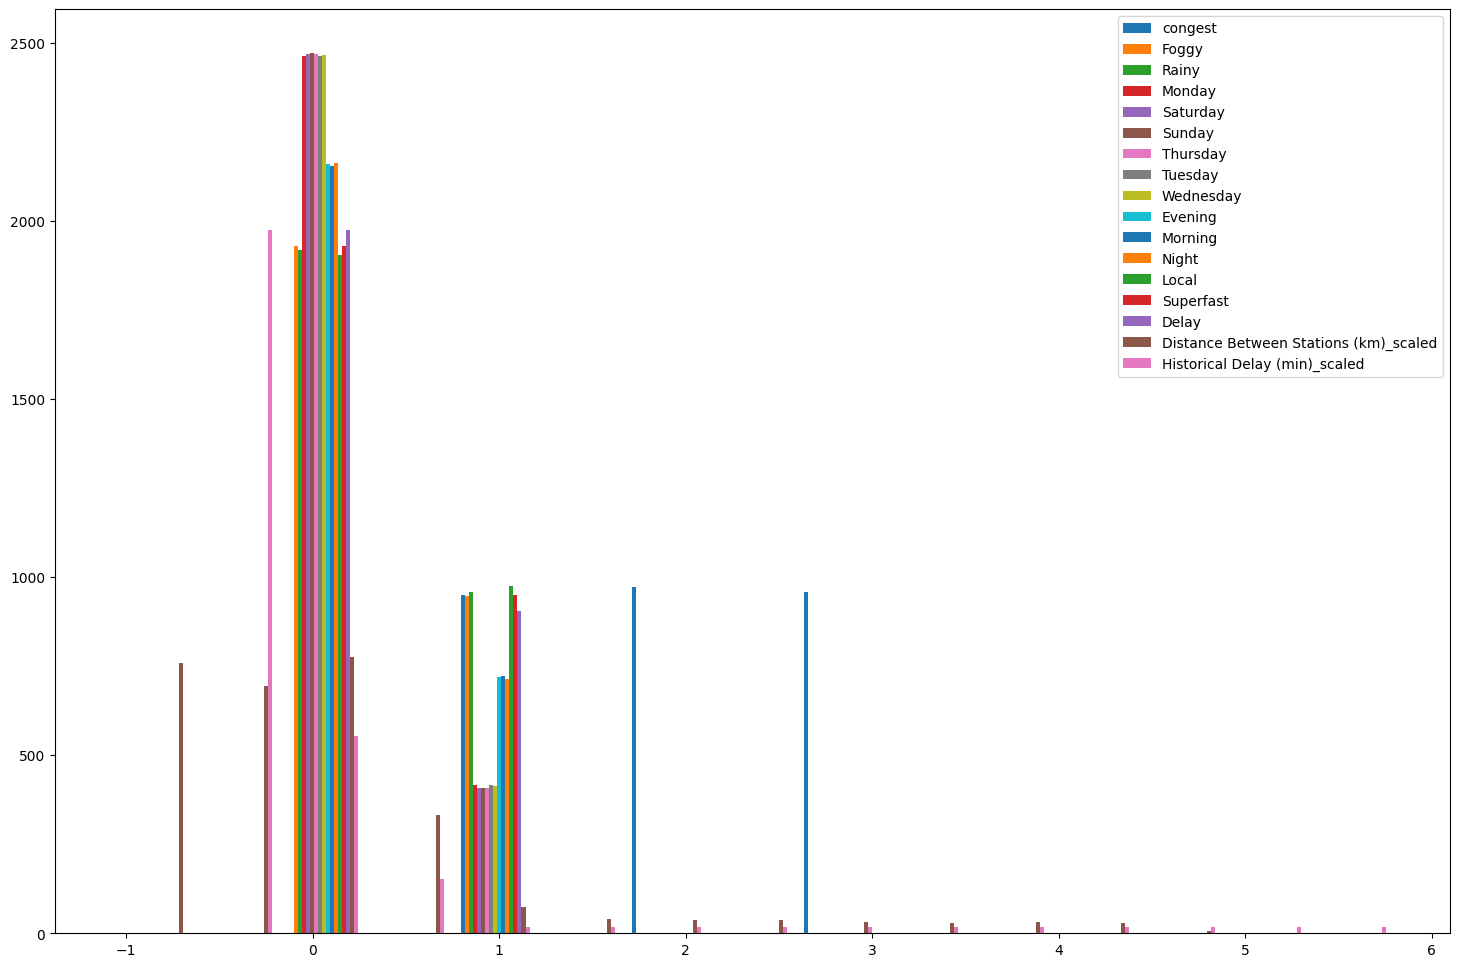

,Distance Between Stations (km),Historical Delay (min),congest,Foggy,Rainy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Evening,Morning,Night,Local,Superfast,Delay,Distance Between Stations (km)_scaled,Historical Delay (min)_scaled
0,100,5,1,False,False,True,False,False,False,False,False,False,True,False,False,False,0,-0.498468,-0.450891
1,150,10,2,False,True,False,False,False,False,True,False,False,False,False,False,True,0,-0.203248,-0.425366
2,200,15,3,True,False,False,False,False,False,False,True,True,False,False,True,False,0,0.091972,-0.399842
3,50,2,1,False,False,False,False,False,True,False,False,False,False,True,False,False,0,-0.793688,-0.466205
4,75,8,2,False,True,False,False,False,False,False,False,False,True,False,False,True,0,-0.646078,-0.435576


In [11]:
scaler = StandardScaler()
columnes = ['Distance Between Stations (km)', 'Historical Delay (min)'] # les columnes que volem escalar
for col in columnes:
    df[f'{col}_scaled'] = scaler.fit_transform(df[[col]])



# Visualització
plt.figure(figsize=(18, 12))
plt.hist([df[c] for c in df.columns][2:19], bins=15, label=[c for c in df.columns][2:19])
plt.legend()
plt.show()
df.head()

#### Models

In [12]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Delay'])

df_train_less = df_train[df_train['Delay'] == 0]
df_test_less = df_test[df_test['Delay'] == 0]
df_train_more = df_train[df_train['Delay'] == 1]
df_test_more = df_test[df_test['Delay'] == 1]

X_train = df_train.drop(['Delay', 'Historical Delay (min)', 'Historical Delay (min)_scaled', 'Distance Between Stations (km)'], axis=1)
y_train = df_train['Delay']
X_test = df_test.drop(['Delay', 'Historical Delay (min)', 'Historical Delay (min)_scaled', 'Distance Between Stations (km)'], axis=1)
y_test = df_test['Delay']

X_train_less = df_train_less.drop(['Delay', 'Historical Delay (min)', 'Historical Delay (min)_scaled', 'Distance Between Stations (km)'], axis=1)
y_train_less = df_train_less['Historical Delay (min)_scaled']
X_test_less = df_test_less.drop(['Delay', 'Historical Delay (min)', 'Historical Delay (min)_scaled', 'Distance Between Stations (km)'], axis=1)
y_test_less = df_test_less['Historical Delay (min)_scaled']

X_train_more = df_train_more.drop(['Delay', 'Historical Delay (min)', 'Historical Delay (min)_scaled', 'Distance Between Stations (km)'], axis=1)
y_train_more = df_train_more['Historical Delay (min)_scaled']
X_test_more = df_test_more.drop(['Delay', 'Historical Delay (min)', 'Historical Delay (min)_scaled', 'Distance Between Stations (km)'], axis=1)
y_test_more = df_test_more['Historical Delay (min)_scaled']

Separem el dataset en train i test, i a més cada bloc en sub-blocs per entrenar els regressors separats segons si hi ha molt o poc retràs. Per començar, entrenem el model classificador.

C:\Users\Usuari\AppData\Local\Temp\ipykernel_2936\1022325727.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Delay',data=df,palette='RdBu_r')


<Axes: xlabel='Delay', ylabel='count'>

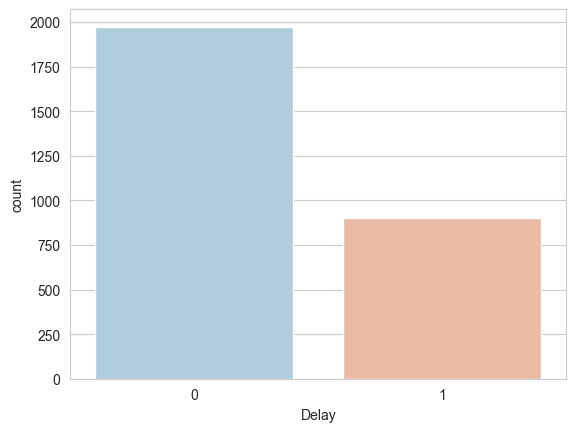

In [13]:
sns.set_style('whitegrid')
sns.countplot(x='Delay',data=df,palette='RdBu_r')

Tenint en compte que el dataset està desbalancejat, ens fixarem amb la mètrica f1, que combina precision i recall. Primer entrenem diversos models i els comparem per decidir quin d'ells és el millor. Per fer-ho, dividim el dataset d'entrenament en 10 folds i entrenem knn, svm, i random forest sobre les particions.

Text(0, 0.5, 'F1-Score')

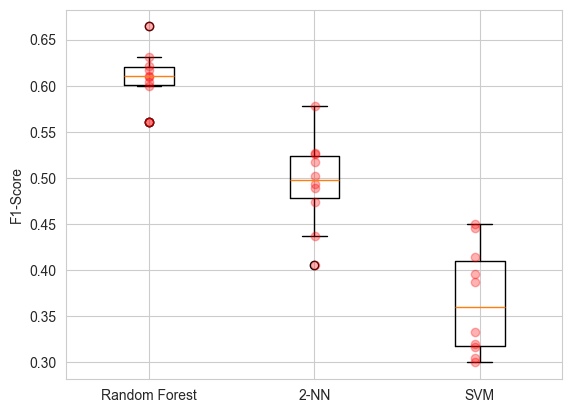

In [14]:
acc_r=np.zeros((10,3))
for i in range(10):

    X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_train, y_train, test_size=0.2)

    knn = KNeighborsClassifier(n_neighbors=2).fit(X_train_k, y_train_k)
    svm = SVC().fit(X_train_k,y_train_k)
    rf = RandomForestClassifier().fit(X_train_k,y_train_k)


    yhat_rf=rf.predict(X_test_k)
    yhat_knn=knn.predict(X_test_k)
    yhat_svm=svm.predict(X_test_k)


    
    acc_r[i][0] = f1_score(y_test_k, yhat_rf)
    acc_r[i][1] = f1_score(y_test_k, yhat_knn)
    acc_r[i][2] = f1_score(y_test_k, yhat_svm)



plt.boxplot(acc_r)
for i in range(3):
    xderiv = (i+1)*np.ones(acc_r[:,i].shape)+(np.random.rand(1,)-0.5)*0.1
    plt.plot(xderiv,acc_r[:,i],'ro',alpha=0.3)

ax = plt.gca()
ax.set_xticklabels(['Random Forest', f'{2}-NN', 'SVM'])
plt.ylabel('F1-Score')


Observem que el random forest proporciona uns resultats més consistents per f1-score, per tant és el model que entrenarem.

A continuació, fem una funció per representar les mètriques visuals.

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, classification_report,confusion_matrix, ConfusionMatrixDisplay, average_precision_score
def grafiques(model,X_test,y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)


    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(2, 2, figure=fig) 

    # ROC Curve
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.axis([-0.1, 1.1, -0.1, 1.1])
    ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc="lower right")

    # Precision-Recall Curve 
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(recall, precision, label=f'AP = {ap:.2f}',color='purple', lw=2)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.axis([-0.1, 1.1, -0.1, 1.1])
    ax2.legend(loc="lower left")

    # Confusion Matrix 
    ax3 = fig.add_subplot(gs[1, :])  
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax3, colorbar=False)
    plt.grid(False)
    ax3.set_title('Confusion Matrix')

    plt.tight_layout()
    plt.show()


Utilitzem la tècnica GridSearch (el dataset és petit, no necessitam recorrer a l'aleatorietat per reduïr el temps) per trobar els millors hiperparàmetres del random forest.

In [16]:
rfc = RandomForestClassifier(random_state=225)
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10, 15],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [5, 25, 50, 100, 200],
    'max_features': [3, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

grid_RFC = GridSearchCV(rfc, param_grid, scoring='f1', n_jobs=-1, verbose=1)
grid_RFC.fit(X_train, y_train)

print("Best RFC params:", grid_RFC.best_params_)
print("Best CV score:", grid_RFC.best_score_)
print(classification_report(y_test, grid_RFC.predict(X_test)))

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best RFC params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_split': 10, 'n_estimators': 200}
Best CV score: 0.6335940100828761
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       395
           1       0.59      0.69      0.63       181

    accuracy                           0.75       576
   macro avg       0.72      0.73      0.72       576
weighted avg       0.76      0.75      0.75       576



Representem les mètriques gràfiques del millor model trobat.

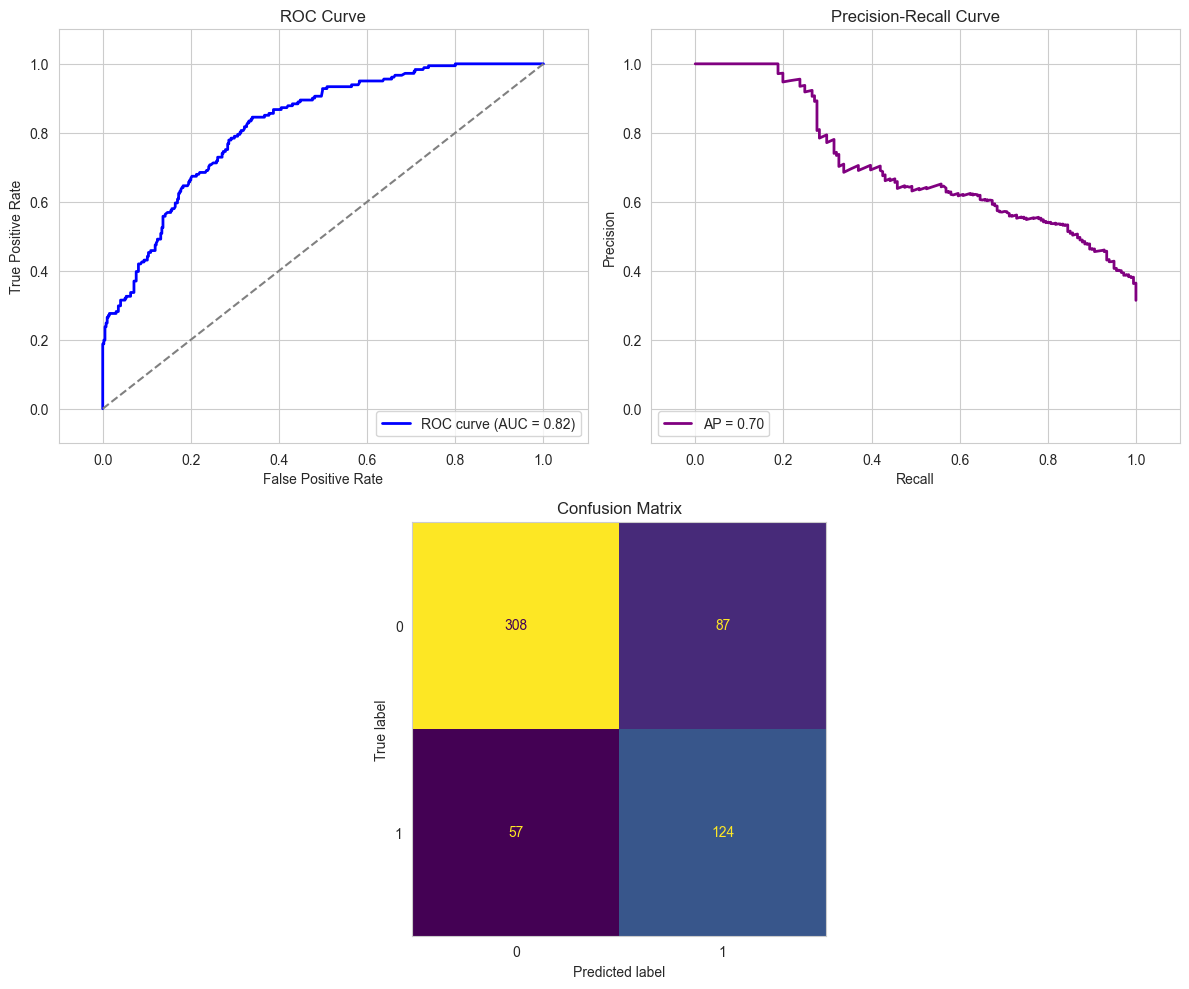

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=3, min_samples_split=10, n_estimators=200,
                       random_state=225)
[0.0299249  0.01954897 0.02001461 0.01588862 0.01655851 0.01258961
 0.01395523 0.01255355 0.01068273 0.02295898 0.01946642 0.01754424
 0.0380489  0.01859005 0.7316747 ]
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       395
           1       0.59      0.69      0.63       181

    accuracy                           0.75       576
   macro avg       0.72      0.73      0.72       576
weighted avg       0.76      0.75      0.75       576



In [17]:
grafiques(grid_RFC.best_estimator_, X_test, y_test)
print(grid_RFC.best_estimator_)
print(grid_RFC.best_estimator_.feature_importances_)
best_classifier = grid_RFC.best_estimator_
pred = best_classifier.predict(X_test)
print(classification_report(y_test, pred))

Per fer els regressors lineals, hem decidit fixar-nos en l'error cuadràtic mitjà, perquè penalitza especialment els errors grans. Fem un primer model lineal per analitzar el comportament dels regressors.

[-1.94631738e-02  2.61919477e-02  5.17128316e-02  6.24313487e-03
  6.33399898e-03  2.97699812e-03 -5.92327198e-03  3.92384504e-03
  2.78508483e-05 -1.99662588e-03 -6.39114440e-03  6.29213529e-03
 -3.66914782e-02  1.87060595e-02 -3.23602429e-03]
0.006848337723172453
[-5.18035592e-04  6.15416246e-01  3.75115295e-01  6.01915354e-02
  5.11440689e-02  3.00545984e-02 -8.66038032e-03  1.17642675e-01
  7.31927370e-02  6.48135261e-02  7.28908239e-02  4.88150358e-02
  3.35025959e-01 -1.67253962e-01  9.11283981e-01]
0.3718820619300133


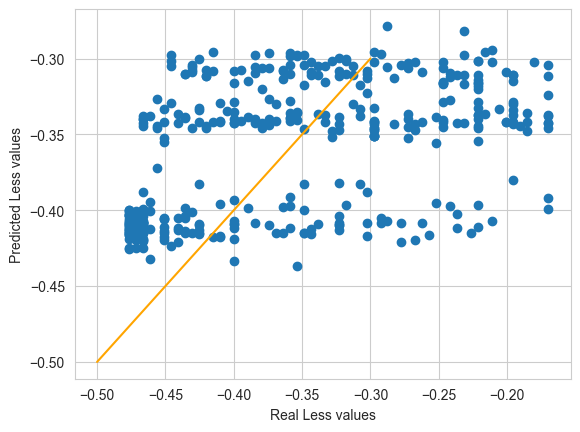

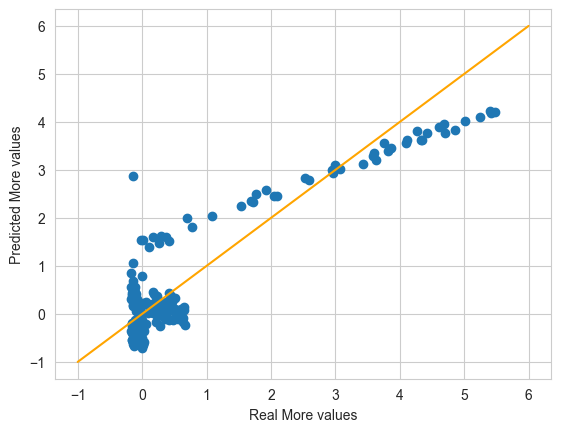

In [18]:
model_less=LinearRegression()
model_less.fit(X_train_less, y_train_less)

y_less_pred = model_less.predict(X_test_less)
mse = mean_squared_error(y_test_less, y_less_pred)
print(model_less.coef_)
print(mse)


model_more=LinearRegression()
model_more.fit(X_train_more, y_train_more) 

y_more_pred = model_more.predict(X_test_more)
mse_more = mean_squared_error(y_test_more, y_more_pred)
print(model_more.coef_)
print(mse_more)

plt.scatter(y_test_less, y_less_pred)
plt.xlabel("Real Less values")
plt.ylabel("Predicted Less values")
plt.plot([-0.5, -0.3], [-0.5, -0.3], c="orange")
plt.show()

plt.scatter(y_test_more, y_more_pred)
plt.xlabel("Real More values")
plt.ylabel("Predicted More values")
plt.plot([-1, 6], [-1, 6], c="orange")
plt.show()

Provem diferents models per maximitzar el rendiment dels valors baixos de retràs: Regressió polinòmica, knn i random forest. Mantenim el criteri amb el mean squared error, que penalitza els errors grans.

{'poly__degree': 2}
0.006167447024224516


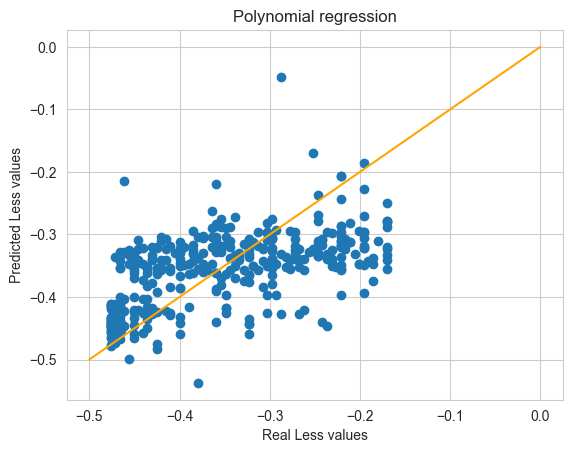

In [19]:
pipe = Pipeline([
    ("poly", PolynomialFeatures()),
    ("linreg", LinearRegression())
])

param_grid = {
    "poly__degree": [1, 2, 3]
}

grid_less_poly = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_less_poly.fit(X_train_less, y_train_less)
y_less_pred = grid_less_poly.predict(X_test_less)

print(grid_less_poly.best_params_)
print(-grid_less_poly.best_score_)

plt.scatter(y_test_less, y_less_pred)
plt.title("Polynomial regression")
plt.xlabel("Real Less values")
plt.ylabel("Predicted Less values")
plt.plot([-0.5, 0], [-0.5, 0], c="orange")
plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.006316713412125527


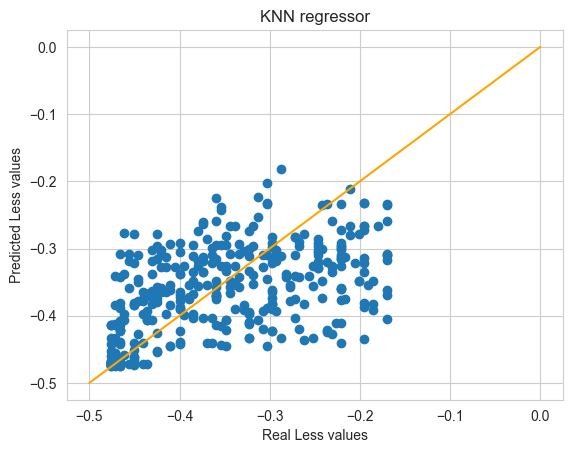

In [20]:
knn = KNeighborsRegressor()
param_knn = {"n_neighbors": [3, 5, 7, 9, 11],"weights": ["uniform"],"p": [1, 2]}

grid_less_knn = GridSearchCV(knn, param_knn, scoring="neg_mean_squared_error", n_jobs=-1, verbose=10)
grid_less_knn.fit(X_train_less, y_train_less)
y_less_pred = grid_less_knn.predict(X_test_less)

print(grid_less_knn.best_params_)
print(-grid_less_knn.best_score_)

plt.scatter(y_test_less, y_less_pred)
plt.title("KNN regressor")
plt.xlabel("Real Less values")
plt.ylabel("Predicted Less values")
plt.plot([-0.5, 0], [-0.5, 0], c="orange")
plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'criterion': 'squared_error', 'max_depth': 10, 'max_features': 3, 'min_samples_split': 2, 'n_estimators': 200}
0.004959248341158696


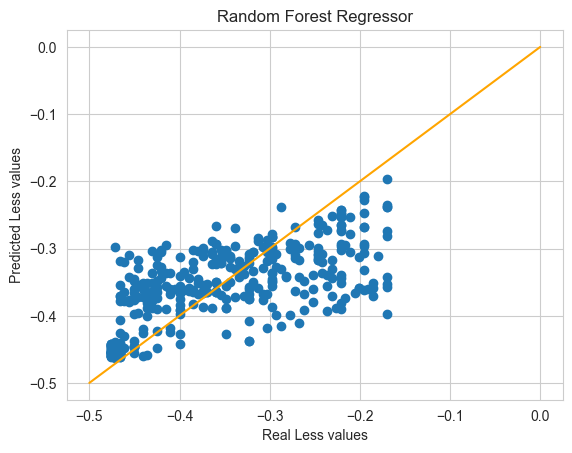

In [21]:
rfr = RandomForestRegressor()
param_grid_rfr = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['squared_error'],
    'n_estimators': [50, 100, 200],
    'max_features': [3, 'sqrt', 'log2']
}

grid_less_rfr = GridSearchCV(rfr, param_grid_rfr, scoring="neg_mean_squared_error", n_jobs=-1, verbose=10)
grid_less_rfr.fit(X_train_less, y_train_less)
y_less_pred = grid_less_rfr.predict(X_test_less)

print(grid_less_rfr.best_params_)
print(-grid_less_rfr.best_score_)

plt.scatter(y_test_less, y_less_pred)
plt.title("Random Forest Regressor")
plt.xlabel("Real Less values")
plt.ylabel("Predicted Less values")
plt.plot([-0.5, 0], [-0.5, 0], c="orange")
plt.show()

In [22]:
# El millor model l'hem obtingut amb random forest
best_less_model = grid_less_rfr.best_estimator_

Ara busquem el millor model per predir els valors alts del retràs. Provarem els models de regressió lineal amb Lasso i Ridge, regressió polinòmica i random forest.

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.35499220931274583
{'alpha': 10}


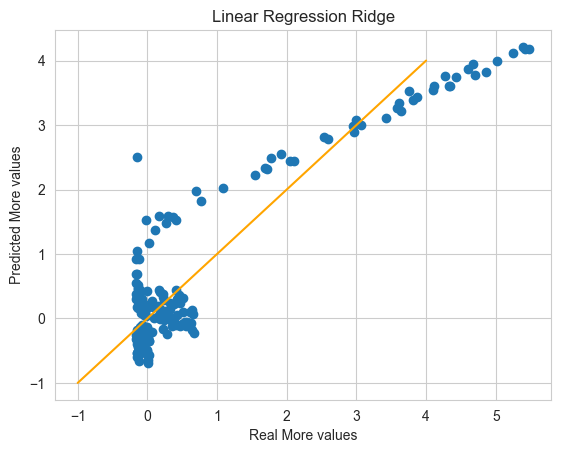

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.34051169461288505
{'alpha': 0.1}


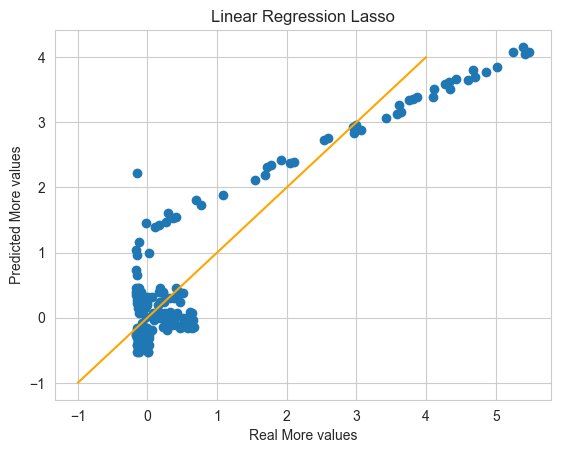

In [23]:
param_more = {"alpha": [0.1, 1, 10, 100, 1000]}
ridge=Ridge()
grid_more_ridge = GridSearchCV(ridge, param_more, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)


grid_more_ridge.fit(X_train_more, y_train_more)
y_more_pred = grid_more_ridge.predict(X_test_more)
mse = mean_squared_error(y_test_more, y_more_pred)
print(mse)
print(grid_more_ridge.best_params_)
plt.scatter(y_test_more, y_more_pred)
plt.title("Linear Regression Ridge")
plt.xlabel("Real More values")
plt.ylabel("Predicted More values")
plt.plot([-1, 4], [-1, 4], c="orange")
plt.show()

lasso=Lasso()
grid_more_lasso = GridSearchCV(lasso, param_more, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)


grid_more_lasso.fit(X_train_more, y_train_more)
y_more_pred = grid_more_lasso.predict(X_test_more)
mse = mean_squared_error(y_test_more, y_more_pred)
print(mse)
print(grid_more_lasso.best_params_)

plt.scatter(y_test_more, y_more_pred)
plt.title("Linear Regression Lasso")
plt.xlabel("Real More values")
plt.ylabel("Predicted More values")
plt.plot([-1, 4], [-1, 4], c="orange")
plt.show()

{'poly__degree': 2}
0.07802986448118189


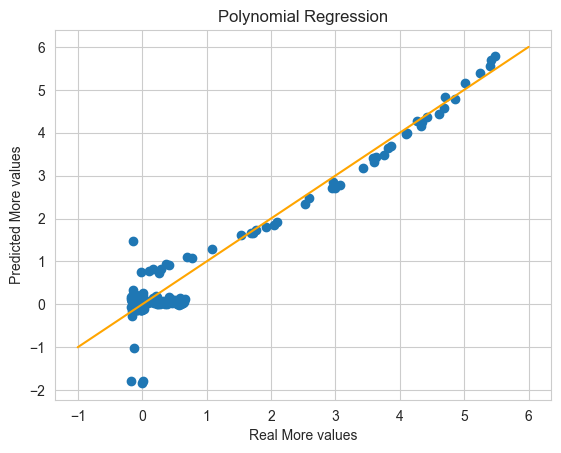

In [24]:
pipe = Pipeline([
    ("poly", PolynomialFeatures()),
    ("linreg", LinearRegression())
])

param_grid = {
    "poly__degree": [2, 3, 4, 5, 6]
}

grid_more_poly = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_more_poly.fit(X_train_more, y_train_more)
y_more_pred = grid_more_poly.predict(X_test_more)

print(grid_more_poly.best_params_)
print(-grid_more_poly.best_score_)

plt.scatter(y_test_more, y_more_pred)
plt.title("Polynomial Regression")
plt.xlabel("Real More values")
plt.ylabel("Predicted More values")
plt.plot([-1, 6], [-1, 6], c="orange")
plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'criterion': 'squared_error', 'max_depth': 10, 'max_features': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.18027743248915057


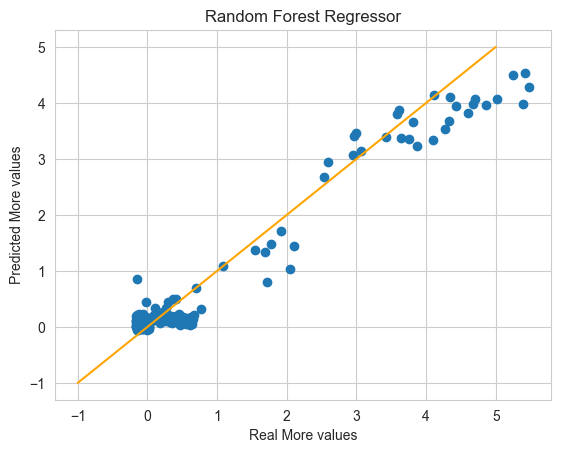

In [25]:
rfr = RandomForestRegressor()
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['squared_error'],
    'n_estimators': [50, 100, 200],
    'max_features': [3, 'sqrt', 'log2']
}

grid_more_rfr = GridSearchCV(rfr, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, verbose=10)
grid_more_rfr.fit(X_train_more, y_train_more)
y_more_pred = grid_more_rfr.predict(X_test_more)

print(grid_more_rfr.best_params_)
print(-grid_more_rfr.best_score_)

plt.scatter(y_test_more, y_more_pred)
plt.title("Random Forest Regressor")
plt.xlabel("Real More values")
plt.ylabel("Predicted More values")
plt.plot([-1, 5], [-1, 5], c="orange")
plt.show()

In [26]:
# El millor model per predir valors amb alt retràs és la regressió polinòmica
best_more_model = grid_more_poly.best_estimator_

### Anàlisi de resultats
En aquest punt, i tinguent els millors models per cada secció, hem de testejar el model sencer, desnormalitzar les dades i els resultats i interpretar-ho. Així, podrem veure l'error mitjà de les dades ($\sqrt{mse}$) en minuts, i veure el comportament real del nostre model.

In [27]:
y_pred_class = pd.Series(best_classifier.predict(X_test), name="y_pred_class")

y_pred_class = pd.Series(
    best_classifier.predict(X_test),
    index=df_test.index,  # alineación perfecta
    name="y_pred_class"
)

In [28]:
df_test2=pd.concat([df_test, y_pred_class], axis=1)
df_test2_less = df_test2[df_test2['y_pred_class'] == 0]
df_test2_more = df_test2[df_test2['y_pred_class'] == 1]
cols=["congest", "Foggy", "Rainy", "Monday", "Saturday","Sunday","Thursday", "Tuesday", "Wednesday","Evening", "Morning","Night", "Local", "Superfast","Distance Between Stations (km)_scaled"]
x_test2_less = df_test2_less[cols]
x_test2_more = df_test2_more[cols]

In [29]:
y_pred_scaled = np.zeros(len(X_test))
for i,value in enumerate(y_pred_class):
    if value == 1:
        y_pred_scaled[i] = best_more_model.predict(X_test.iloc[[i]])[0]
    else:
        y_pred_scaled[i] = best_less_model.predict(X_test.iloc[[i]])[0]

# Desnormalitzem
xyscaled = np.column_stack([
    df_test["Distance Between Stations (km)_scaled"],  # columna 1 escalada
    y_pred_scaled                                      # columna 2 escalada (predicció)
])
y_pred_real=scaler.inverse_transform(xyscaled)
y_pred_real=y_pred_real[:,1]


mse_total = mean_squared_error(df_test["Historical Delay (min)"], y_pred_real)
print("RMSE total del model híbrid:", np.sqrt(mse_total))


RMSE total del model híbrid: 54.79615933474176


In [30]:
y_pred_more2=pd.Series(best_more_model.predict(x_test2_more), name="y_pred_more")
y_pred_less2=pd.Series(best_less_model.predict(x_test2_less), name="y_pred_less")

In [31]:
mask_more = (y_pred_class == 1)
mask_less = (y_pred_class == 0)

mse_more = mean_squared_error(df_test["Historical Delay (min)"][mask_more], y_pred_real[mask_more])
mse_less = mean_squared_error(df_test["Historical Delay (min)"][mask_less], y_pred_real[mask_less])

print("MSE (more delay):", mse_more)
print("MSE (less delay):", mse_less)

print("RMSE (more delay):", np.sqrt(mse_more))
print("RMSE (less delay):", np.sqrt(mse_less))


MSE (more delay): 6701.907580754429
MSE (less delay): 864.1262720431162
RMSE (more delay): 81.8651792934849
RMSE (less delay): 29.396024765997122


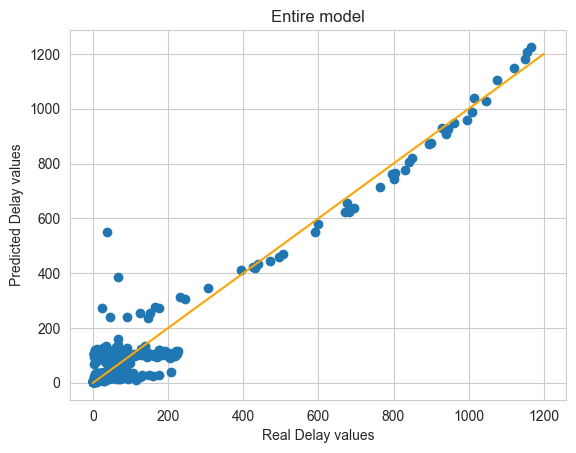

In [32]:
plt.scatter(df_test["Historical Delay (min)"], y_pred_real)
plt.xlabel("Real Delay values")
plt.ylabel("Predicted Delay values")
plt.plot([-1, 1200], [-1, 1200], c="orange")
plt.title("Entire model")
plt.show()

Els punts clarament erronis, i que no apareixien durant el test dels models per separat mostren com actua el model davant errors en el classificador (la normalització/desnormalització són transformacions lineals). És interessant com, a partir de les 3 hores, el model pot predir amb molta exactitud el retràs. Això pot ser més important que predir els petits retrassos si l'objectiu de l'empresa és, per exemple, evitar indemnitzacions. S'ha de tenir en compte també que els retrassos menors poden tenir molts motius: hores puntes, averies puntuals, retràs acumulat de la linia al llarg del dia, la linia en concret... Tot això són factors que no venen recollits a la nostra base de dades, i fan que el model no sigui fiable per petits retrassos.